In [1]:
from FK import *
import pyvoro
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import numba as nb
from tqdm import tqdm

In [2]:
%matplotlib notebook

In [3]:
def area_vertices(vertices):
    f_cm = np.mean(vertices,axis=0)
    vertices = vertices - f_cm
    i_1 = np.arange(len(vertices))
    i_2 = (i_1+1)%len(i_1)
    A = [np.cross(vertices[i_1[j]],vertices[i_2[j]]) for j in range(len(i_1))]
    area = np.linalg.norm(np.sum(A,axis=0)/2)
    return area

In [4]:
def sphere_sample(n):
    samples = []
    for i in range(n):
        v = [0, 0, 0]  # initialize so we go into the while loop

        while np.linalg.norm(v) < .0001:
            x = np.random.normal()  # random standard normal
            y = np.random.normal()
            z = np.random.normal()
            v = np.array([x, y, z])

        v = v/np.linalg.norm(v)  # normalize to unit norm
        
        samples.append(v)
        
    return np.array(samples)

def isinside(v, vt_polygon):
    len_vt = len(vt_polygon)
    list_inside = [np.dot(v,np.cross(vt_polygon[i],vt_polygon[(i+1)%len_vt]))<=0
               for i in range(len_vt)]
    return np.all(list_inside) 

def elastic_energy(Faces, Vertices, Vect_sample, fraction = 0.5, elas_const = 1.0):
    n_sample = len(Vect_sample)
    # volume of uniformly distributed, undeformed sphere
    radius_sphere = (1/(4/3*np.pi))**(1/3)
    r_OS = radius_sphere
    r_OI = r_OS*fraction
    r_IS = r_OS-r_OI
    
    E = 0
    r = 0
    # iterate over facets
    for i_faces, face in enumerate(Faces):
        vt_sf_list = Vertices[face['vertices']].tolist()
        vt_if_list = (Vertices[face['vertices']]*fraction).tolist() # interface position

        v0 = np.array(vt_sf_list[0])
        v1 = np.array(vt_sf_list[1])
        v2 = np.array(vt_sf_list[2])
        v0_i = np.array(vt_if_list[0])

        n_sf = np.cross((v1-v0),
                        (v1-v2))
        n_sf = n_sf/np.linalg.norm(n_sf)

        index_inside = [isinside(v,vt_sf_list) for v in Vect_sample]
        vect_inside = Vect_sample[index_inside]

        for vect in vect_inside:
            d_OS = np.abs(np.dot(v0,n_sf)/np.dot(vect,n_sf))
            d_OI = np.abs(np.dot(v0_i,n_sf)/np.dot(vect,n_sf))
            d_IS = d_OS-d_OI

            stretch_OI = d_OI-r_OI
            stretch_IS = d_IS-r_IS

            E += elas_const*(stretch_OI**2)/2 + elas_const*(stretch_IS**2)/2
            r += d_OS

    return E/n_sample, r/n_sample

### Select Voronoi polyhedra and evaluate strain energy

In [5]:
n_x = 1
n_y = 1
n_layers = 1

# Choose c/a ratio here
# r_ca = [228/431]
# r_ca = [1/1.9]
# r_ca = [0.518]
# r_ca = [1/np.sqrt((1+np.sqrt(3)/2)**2+0.5**2)]
r_ca = np.linspace(0.4,0.6,41)

IQ_arr = []
counts_arr = []
volume_arr = []
E_arr = []
r_arr = []

progress = tqdm(total=len(r_ca))
for i_r, r in enumerate(r_ca):
    e_SQ = np.array([[np.cos(x),np.sin(x)] for x in [0,np.pi/2]])
    e_TR = np.array([[np.cos(x),np.sin(x)] for x in [0,np.pi/3]])
    
    l_c = 1*np.sqrt((1+np.sqrt(3)/2)**2+0.5**2)*r
#     print(l_c)
    
    # Generate a FK A15 primitive unit cell
    c_layer_A15 = c_A15(n_x,n_y,Ratio_ca=1/r)
    c_rod = stack_coords([shift_coords(c_layer_A15, np.array([0,0,l_c])*s) for s in range(n_layers)])

    l = 1.0
    bounds = np.array([[0,n_x*l],[0,n_y*l],[0,n_layers*l_c]])
    points = np.vstack(c_rod)
    
    # Call pyvoro.compute_voronoi function to evaluate the Voronoi tessellations
    voro = pyvoro.compute_voronoi(points,bounds,0.7,periodic=[True]*3)
    
    list_origin = [v['original'] for v in voro]
    list_volume = [v['volume'] for v in voro]
    list_volume_round = [np.round(v['volume'],decimals=9) for v in voro]
    list_vertices = [v['vertices'] for v in voro]
    list_adjacency = [v['adjacency'] for v in voro]
    list_faces = [v['faces'] for v in voro]
    list_coords = [len(v['faces']) for v in voro]
    
    # Pick up the unique elements from the list of Voronoi cell volume
    unique_volume, inices, counts = np.unique(list_volume_round,return_counts=True,return_index=True)
    unique_volume_reduced = unique_volume*np.sum(counts)/np.sum(counts*unique_volume)
    unique_adjacency = np.array(list_coords)[inices]
    
    # Isoperimetric quotient (IQ)
    unique_IQ = []
    for i_cell in range(len(unique_volume)):
        vertices = np.array(list_vertices[inices.tolist()[i_cell]])
        v_cm = np.mean(vertices,axis=0)
        vertices = vertices-v_cm
        faces = list_faces[inices.tolist()[i_cell]]
    
        area_sum = 0
        for i_faces, face in enumerate(faces):
            vertices_face_list = vertices[face['vertices']].tolist()
            area = area_vertices(vertices_face_list)
            area_sum += area
            
        unique_IQ.append(36*np.pi*unique_volume[i_cell]**2/area_sum**3)
        
    IQ_arr_i = np.array(unique_IQ)
    IQ_arr.append(IQ_arr_i)
    counts_arr.append(counts)
    volume_arr.append(unique_volume_reduced)
    
    # scale the unitcell volume such that the averaged Voronoi cell volume = 1
    unit_cell_volume = np.sum(counts*unique_volume)
    volume_ratio = np.sum(counts)/unit_cell_volume
    size_ratio = volume_ratio**(1/3)

    # material dependent parameters
    f = 0.5 # fraction of core segment
    Ek = 1.0 # elastic constant
    
    # elastic strain energy
    E_arr_i = []
    r_arr_i = []
    for i_cell in range(len(unique_volume)):
        # randomly generated radial vectors
        n_sample = 2000
        vect_sample = sphere_sample(n_sample)

        # vertices of Voronoi cell
        vertices = np.array(list_vertices[inices.tolist()[i_cell]])*size_ratio
        v_cm = np.mean(vertices,axis=0)
        vertices = vertices-v_cm
        faces = list_faces[inices.tolist()[i_cell]]

        E, r = elastic_energy(Faces=faces, Vertices=vertices, Vect_sample=vect_sample)
        E_arr_i.append(E)      
        r_arr_i.append(r)   
    
    E_arr.append(E_arr_i)
    r_arr.append(r_arr_i)
    
    progress.update(1)
    
IQ_arr = np.array(IQ_arr)
counts_arr = np.array(counts_arr)
volume_arr = np.array(volume_arr)
E_arr = np.array(E_arr)
r_arr = np.array(r_arr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [13:18<00:00, 17.47s/it]

In [16]:
def quadratic_fit(r,F):
    ## quadratic fit
    r_poly = np.c_[r**0,r**1,r**2]
    x = (F.T@r_poly)@np.linalg.inv(r_poly.T@r_poly)
    return x

def cubic_fit(r,F):
    ## quadratic fit
    r_poly = np.c_[r**0,r**1,r**2,r**3]
    x = (F.T@r_poly)@np.linalg.inv(r_poly.T@r_poly)
    return x

<IPython.core.display.Javascript object>


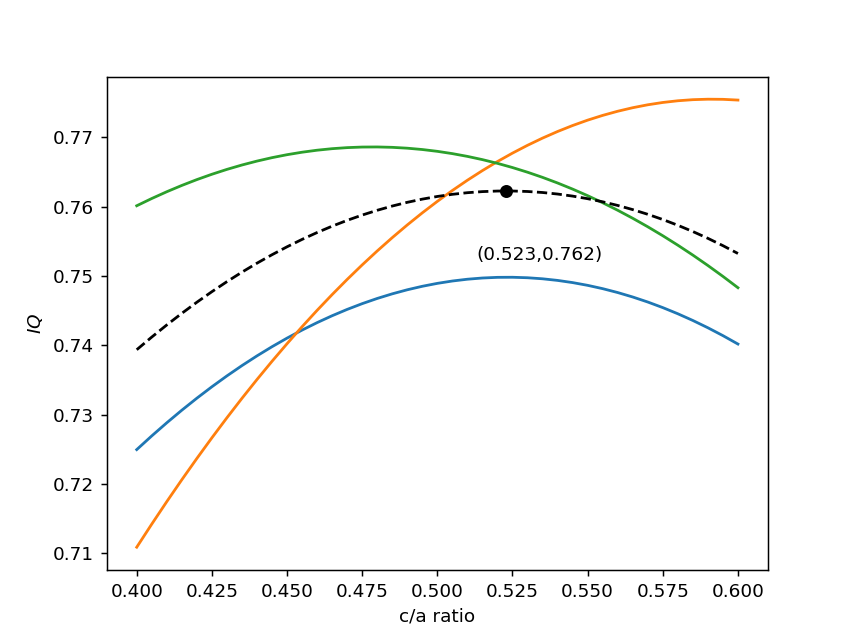

Text(0, 0.5, '$IQ$')

In [34]:
r_ca = np.linspace(0.4,0.6,41)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']

## switch
IQ_new = IQ_arr.copy()
IQ_new[r_ca>0.525,1] = IQ_arr[r_ca>0.525,2]
IQ_new[r_ca>0.525,2] = IQ_arr[r_ca>0.525,1]

for i_cell in range(len(unique_volume)):
    IQ_arr_i = IQ_new[:,i_cell]
    x_fit = quadratic_fit(r_ca,IQ_arr_i)
    IQ_arr_fit = x_fit[0] + x_fit[1]*r_ca + x_fit[2]*r_ca**2

#     ax.plot(r_ca,IQ_arr_i,'.',color=colors[i_cell])
    ax.plot(r_ca,IQ_arr_fit,'-',color=colors[i_cell])

#     ax.plot(r_ca[index_max],IQ_arr_i[index_max],'o',color=colors[i_cell])

    
IQ_arr_ave = np.sum(IQ_arr*counts_arr*volume_arr,axis=1)/np.sum(counts_arr*volume_arr,axis=1)
index_IQ_max_ave = IQ_arr_ave==np.max(IQ_arr_ave)
x_fit = quadratic_fit(r_ca,IQ_arr_ave)
E_arr_fit = x_fit[0] + x_fit[1]*r_ca + x_fit[2]*r_ca**2
r_min_ave = -x_fit[1]/2/x_fit[2]
E_min_ave = x_fit[0] + x_fit[1]*r_min_ave + x_fit[2]*r_min_ave**2

# ax.plot(r_ca,IQ_arr_ave,'--k')
ax.plot(r_ca,E_arr_fit,'--k')
ax.plot(r_min_ave,E_min_ave,'ok')
str_coord = '({:0.3f},{:0.3f})'.format(r_min_ave,E_min_ave)
ax.text(r_min_ave-0.01,E_min_ave-0.01,
        s=str_coord)
ax.set_xlabel('c/a ratio')
ax.set_ylabel(r'$IQ$')

<IPython.core.display.Javascript object>


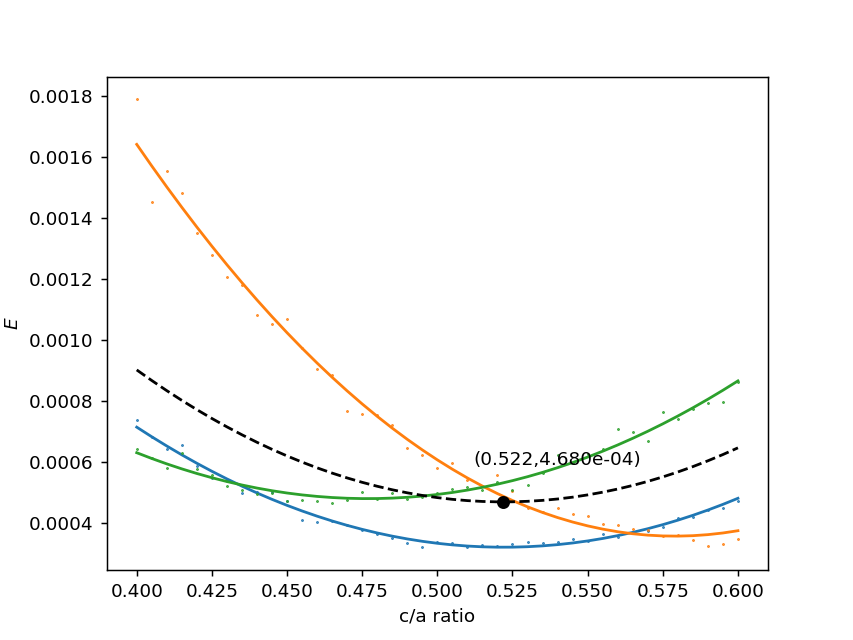

Text(0, 0.5, '$E$')

In [32]:
r_ca = np.linspace(0.4,0.6,41)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']

## switch
E_new = E_arr.copy()
E_new[r_ca>0.525,1] = E_arr[r_ca>0.525,2]
E_new[r_ca>0.525,2] = E_arr[r_ca>0.525,1]

# energy per cell
for i_cell in range(len(unique_volume)):
    E_arr_i = E_new[:,i_cell]
    x_fit = quadratic_fit(r_ca,E_arr_i)
    E_arr_fit = x_fit[0] + x_fit[1]*r_ca + x_fit[2]*r_ca**2
    
    ax.plot(r_ca,E_arr_i,'.',color=colors[i_cell], ms=1)
    ax.plot(r_ca,E_arr_fit,'-',color=colors[i_cell])

# averaged energy
E_arr_ave = np.sum(E_arr*counts_arr*volume_arr,axis=1)/np.sum(counts_arr*volume_arr,axis=1)
x_fit = quadratic_fit(r_ca,E_arr_ave)
E_arr_fit = x_fit[0] + x_fit[1]*r_ca + x_fit[2]*r_ca**2
r_min_ave = -x_fit[1]/2/x_fit[2]
E_min_ave = x_fit[0] + x_fit[1]*r_min_ave + x_fit[2]*r_min_ave**2

ax.plot(r_ca,E_arr_fit,'--k')
ax.plot(r_min_ave,E_min_ave,'ok')
str_coord = '({:0.3f},{:0.3e})'.format(r_min_ave,E_min_ave)
ax.text(r_min_ave-0.01,E_min_ave+0.00012,
        s=str_coord)

ax.set_xlabel('c/a ratio')
ax.set_ylabel(r'$E$')

<IPython.core.display.Javascript object>


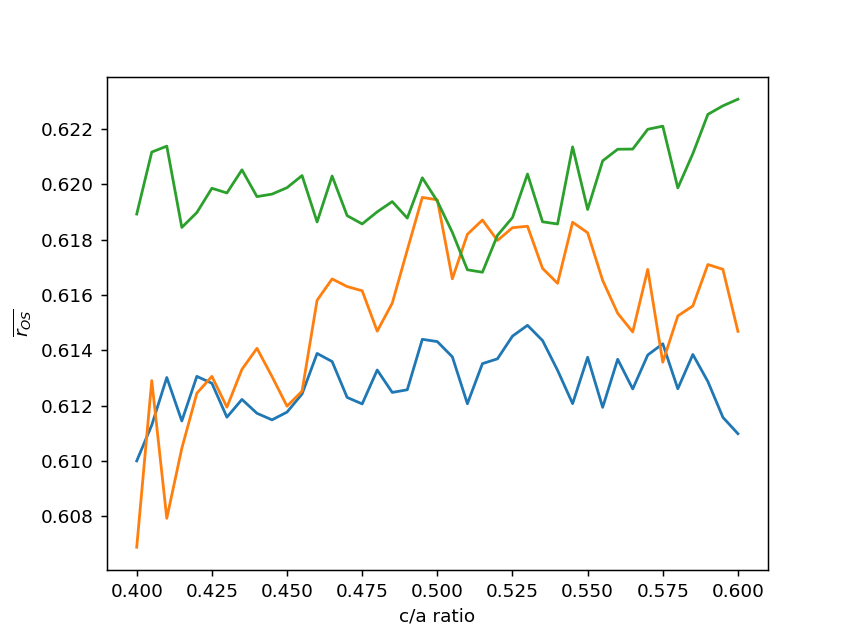

Text(0, 0.5, '$\\overline{r_{OS}}$')

In [10]:
r_ca = np.linspace(0.4,0.6,41)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
colors = ['C0','C1','C2','C3','C4']

for i_cell in range(len(unique_volume)):
    r_arr_i = r_arr[:,i_cell]

    ax.plot(r_ca,r_arr_i,'-',color=colors[i_cell])

ax.set_xlabel('c/a ratio')
ax.set_ylabel(r'$\overline{r_{OS}}$')

In [11]:
unique_IQ

[0.7414910696834659, 0.7495887075880203, 0.7760794374367976]